In [1]:
import pandas as pd
from matplotlib import pyplot as plt
from TCGA_files import *
from gtex import get_gtex_tissue
import seaborn as sns
import sys, os
from hsbmpy import topic_distr_isample, topic_distr_sample,get_file, get_tissue_style, get_max_available_L
from TCGA_files import get_tcga_tissue

In [2]:
label=""
algorithm = "topsbm"
directory='/home/jovyan/work/phd/datasets/gtex/10'
L = get_max_available_L(directory, algorithm)
os.chdir(directory)

In [3]:
df = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,L))
df.head()

,i_doc,doc,Topic 1,Topic 2,Topic 3,Topic 4,Topic 5,Topic 6,Topic 7,Topic 8,Topic 9,Topic 10,Topic 11
0,0,GTEX-1GZ2Q-0011-R6a-SM-9OSWM,0.025273,0.739032,0.214179,0.021443,0.0,0.000073,0.0,0.0,0.0,0.0,0.0
1,1,GTEX-RU72-0011-R5A-SM-2TF6U,0.019600,0.770408,0.186643,0.023258,0.0,0.000091,0.0,0.0,0.0,0.0,0.0
2,2,GTEX-WHSE-0011-R3A-SM-3P5ZM,0.021793,0.731816,0.239283,0.006984,0.0,0.000125,0.0,0.0,0.0,0.0,0.0
3,3,GTEX-14PQA-0011-R1b-SM-6EU1G,0.019069,0.841035,0.135838,0.003976,0.0,0.000081,0.0,0.0,0.0,0.0,0.0
4,4,GTEX-13CF2-0011-R1a-SM-5LZY1,0.016199,0.835797,0.142693,0.005046,0.0,0.000266,0.0,0.0,0.0,0.0,0.0


### Specific topic

In [ ]:
topic = 15

In [ ]:
searchdf = df.sort_values(by="Topic %d"%topic, ascending=False).loc[:,['doc','Topic %d'%topic]]
searchdf.head()

In [ ]:
#datatotest = queryFiles([f[0]+'.FPKM.txt.gz' for f in searchdf.values[:30] if f[1]>0.1])
#datatotest = queryFiles([f[0] for f in searchdf.values[:10]])
datatotest = pd.DataFrame(columns=['primary_site','secondary_site'])
for file in [f[0] for f in searchdf.values[:10]]:
    datatotest=datatotest.append(get_gtex_tissue(file))
datatotest

In [ ]:
makeTopicPie(datatotest, L, ['primary_site','secondary_site'])

In [ ]:
df_file=pd.read_csv("files.dat", index_col=[0])
samples = []
for sample in df['doc']:
    if 'Lung' in get_gtex_tissue(sample)['primary_site']:
        samples.append(sample)

In [ ]:
tissuedf = df[df['doc'].isin(samples)].drop('i_doc', axis=1)
tissuedf.mean(axis=0).sort_values(ascending=False)

## topic distr

In [ ]:
for idoc in searchdf.index.values[:5]:
    fig=plt.figure()
    ax=fig.subplots()
    topic_distr_isample(idoc,df,ax)
    plt.show()
    fig.savefig("topic_distr_%d.png"%idoc)

In [ ]:
for idoc in np.random.randint(len(df.index), size=10):
    topic_distr_isample(idoc, df)

## Topic distr

### kl

In [ ]:
l=L

In [ ]:
df_kl = pd.read_csv("%s/topsbm/topic-kl_%d.csv"%(directory,l), header=None)
df_kl.columns = ['first', 'second', 'kl']
df_kl.head()

In [ ]:
df_cluster = pd.read_csv("%s/topsbm/topsbm_level_%d_clusters.csv"%(directory,l))
df_topics = pd.read_csv("%s/topsbm/topsbm_level_%d_topic-dist.csv"%(directory,l)).loc[:,df.columns[2:]]
df_files = pd.read_csv("%s/files.dat"%(directory), index_col=[0], header=0)

In [ ]:
bins = np.linspace(-0.025,1.025,40)

In [ ]:
sites = df_files[label].unique()
df_tissue_kl = pd.DataFrame(index=sites, columns=sites, dtype=float)

In [ ]:
for tissue_row in sites:
    cluster_row = df_files[df_files['primary_site']==tissue_row].index.values
    for tissue_column in sites:
        print(tissue_row, tissue_column)
        cluster_column = df_files[df_files['primary_site']==tissue_column].index.values
        datarc = df_kl[(df_kl['first'].isin(cluster_row) & df_kl['second'].isin(cluster_column))]['kl'].values
        datacr = df_kl[(df_kl['first'].isin(cluster_column) & df_kl['second'].isin(cluster_row))]['kl'].values
        df_tissue_kl.at[tissue_row,tissue_column]=(np.average(np.concatenate((datarc,datacr))))

In [ ]:
h = sns.clustermap(df_tissue_kl.dropna(axis=0,how='all').dropna(axis=1, how='any'), cmap=sns.diverging_palette(15,250, n=15), metric='euclidean')
dn = h.dendrogram_col.dendrogram
h.fig.savefig("%s/topic_distr_kl_map.pdf"%directory)

In [ ]:
import scipy.cluster.hierarchy as shc
fig = plt.figure(figsize=(12,8))
ax = fig.subplots()
ax.set_xlabel("kl correlation", fontsize=16)
dend = shc.dendrogram(h.dendrogram_col.linkage, labels=df_tissue_kl.columns, orientation='right', distance_sort='discending', ax=ax)
fig.savefig("%s/topic_dist_dendogram_level(%d).pdf"%(directory,l))

### Topic maps

In [18]:
l=L-2

In [19]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
df_files = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics.set_index('doc', inplace=True)
df_topics.insert(0,'tissue','')
df_topics.drop('i_doc', axis=1, inplace=True)
label = "SMTS"
if label not in df_files.columns:
    raise AttributeError(f"{label} not valid. Available: {df_files.columns}")

In [20]:
for sample in df_topics.index.values:
    try:
        df_topics.at[sample,'tissue']=("%s"%(get_file(sample,df_files)[label]))
    except:
        #print(*sys.exc_info())
        df_topics.at[sample,'tissue']="unknown"

In [21]:
df_cmap = df_topics.sort_values(by='tissue').set_index('tissue').transpose()
df_cmap = df_cmap.subtract(df_cmap.mean(axis=1),axis=0)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

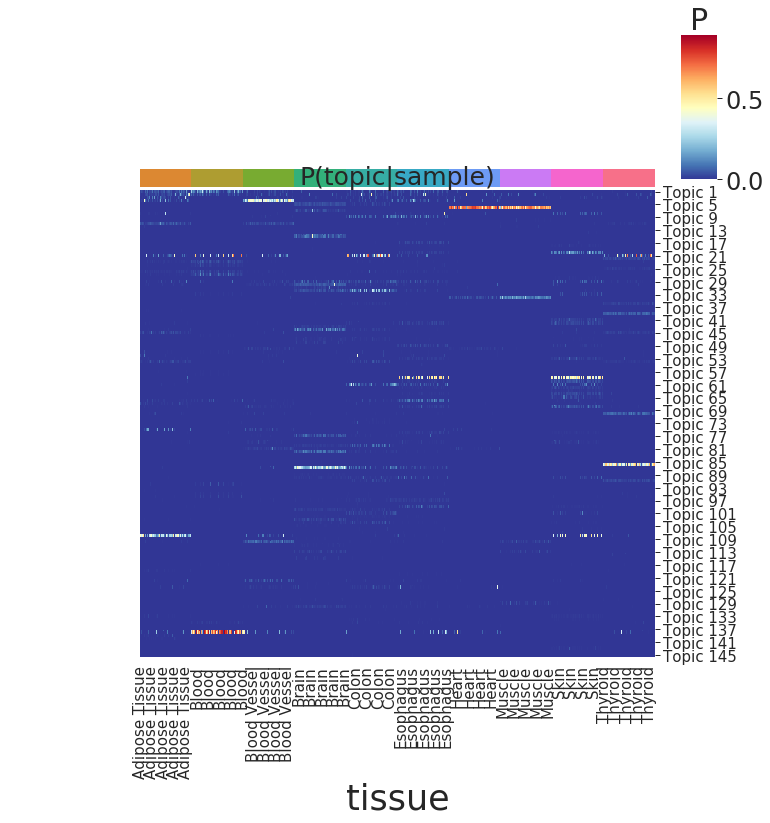

In [27]:
cm = sns.clustermap(df_cmap, 
                    row_cluster=False, 
                    col_cluster=False, 
                    metric='euclidean', 
                    vmin=0, 
                    cmap='RdYlBu_r', 
                    col_colors=network_col,
                    cbar_pos=(0.95,0.8,0.05,0.2)
                    )
ax = cm.ax_heatmap
ax.tick_params(labelsize=15)
ax.set_xlabel("tissue", fontsize=35)
ax.set_title("P(topic|sample)", fontsize=25)
cax = cm.ax_cbar
cax.tick_params(labelsize=24)
cax.set_title("P", fontsize=30)
cm.fig.savefig("%s/MAP_level%d.pdf"%(algorithm,l))

In [28]:
for g in pd.read_csv("%s/%s_level_%d_topics.csv"%(algorithm,algorithm,l))["Topic 10"].dropna():
    print(g)

ENSG00000187550.8
ENSG00000265142.8
ENSG00000235263.1
ENSG00000225613.2
ENSG00000236958.1
ENSG00000118702.9
ENSG00000159248.4
ENSG00000138472.10
ENSG00000231536.1
ENSG00000250981.1
ENSG00000228826.2
ENSG00000255946.1
ENSG00000283217.1


In [22]:
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm, algorithm,l))
df_topics.drop('i_doc', axis=1, inplace=True)
df_topics.set_index('doc', inplace=True)
for sample in df_topics.index.values:
    df_topics.at[sample,'tissue']="%s"%(get_file(sample,df_files)[label])

Brain
Skin
Esophagus
Blood Vessel
Adipose Tissue
Blood
Heart
Muscle
Colon
Thyroid


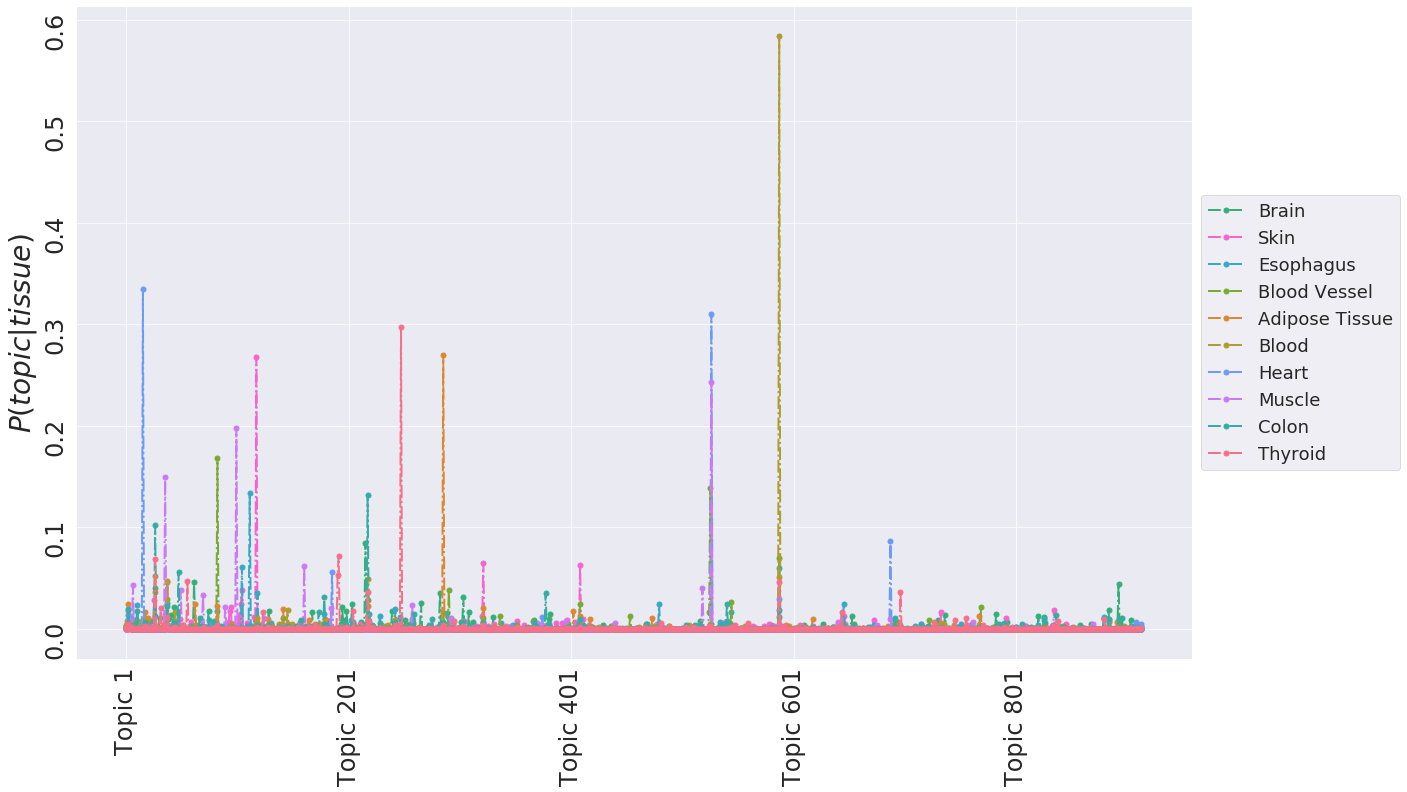

In [23]:
fig,ax = plt.subplots(figsize=(25,12))
for tissue in df_topics['tissue'].unique():
    print(tissue)
    marker, c, ls = get_tissue_style(tissue)
    try:
        df_topics[df_topics['tissue']==tissue].loc[:,df_topics.columns[0:]].mean(axis=0).plot(ls=ls,marker=marker, lw=2, ms=10, ax=ax, label=tissue, c=network_lut[df_files[df_files[label]==tissue][label][0]])
    except:
        print(*sys.exc_info())
ax.tick_params(rotation=90, labelsize=24)
ax.set_ylabel("$P(topic | tissue)$", fontsize=28)
#plt.xscale('log')
#plt.yscale('log')

# Shrink current axis by 20%
box = ax.get_position()
ax.set_position([box.x0, box.y0, box.width * 0.8, box.height])

# Put a legend to the right of the current axis
ax.legend(fontsize=18, ncol=1, loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()
fig.savefig("%s/lifeplot_level%d.pdf"%(algorithm,l))

In [ ]:
import tensorflow as tf

In [ ]:
df_files_pd = pd.read_csv("files.dat", index_col=0).dropna(how='all', axis=0)
df_topics = pd.read_csv("%s/%s_level_%d_topic-dist.csv"%(algorithm,algorithm,l))
df_files = pd.read_csv("files.dat")
df_topics.insert(0,"status",['healthy' if 'GTEX' in x else 'tumour' for x in df_topics["doc"]])
df_topics.insert(0,'tissue',[get_file(x, df_files_pd)[label] for x in df_topics["doc"]])

In [ ]:
df_topic_list = pd.read_csv("%s/%s_level_%d_topics.csv"%(algorithm,algorithm,l))

### only health vs disease

In [ ]:
dftf_h = tf.convert_to_tensor(df_topics[df_topics["status"]=="healthy"].drop(['doc','i_doc', 'status', 'tissue'], axis=1).astype(float).values)
dftf_d = tf.convert_to_tensor(df_topics[df_topics["status"]=="tumour"].drop(['doc','i_doc', 'status', 'tissue'], axis=1).astype(float).values)

In [ ]:
results = tf.sort([tf.math.reduce_mean(dftf_h,0),tf.math.reduce_mean(dftf_d,0)], axis=1, direction='DESCENDING').numpy()

In [ ]:
fig = plt.figure(figsize=(20,10))
plt.plot(results[0], marker='o', lw=0.1)
plt.plot(results[1],marker='x', lw=0.1)
plt.yscale('log')
plt.xscale('log')
plt.show()

In [ ]:
df_topics.groupby('tissue').count()

In [ ]:
for topic in topic_cols:
    plt.figure(figsize=(15,8))
    plt.title(topic)
    for tissue in df_topics.select('second_tissue').distinct().toPandas().values.T[0]:
        tissue_spec=(df_topics.filter(col('second_tissue')==tissue).select([topic]).toPandas().astype(float)-means[topic].values)/sigmas[topic].values
        plt.hist(tissue_spec.values.T[0], density=True, histtype='step', label=tissue)
    plt.xscale('log')
    plt.yscale('log')
    plt.legend()
    plt.show()

In [ ]:
df_topics_grouped = df_topics.groupby('second_tissue').agg({x: 'avg' for x in topic_cols}).toPandas().set_index('second_tissue')[["avg(%s)"%t for t in topic_cols]].transpose()
df_topics_grouped.index=topic_cols

In [ ]:
df_cmap = df_topics_grouped
df_cmap=df_cmap.subtract(df_cmap.mean(axis=1), axis=0).divide(df_cmap.std(axis=1), axis=0)
df_cmap.sort_index(axis=1, inplace=True)
#df_cmap.sort_values(by=[c for c in df_cmap.columns[::2]], inplace=True)
#create a color palette with the same number of colors as unique values in the Source column
network_pal = sns.color_palette('husl',n_colors=len(df_cmap.columns))

#Create a dictionary where the key is the category and the values are the
#colors from the palette we just created
network_lut = dict(zip(df_cmap.columns, network_pal))
network_col = df_cmap.columns.map(network_lut)

fig = plt.figure()
cm = sns.clustermap(df_cmap, row_cluster=False, col_cluster=False, metric='euclidean', cmap='RdYlBu', col_colors=network_col)
cm.fig.savefig("%s/MAP_level%d.png"%(directory,l))

In [ ]:
fig=plt.figure(figsize=(10,8))
#plt.plot((df_tissue).values[0], label=look_for[0], ls='--', ms=10)
plt.hist((df_tissue_healthy).values[0], label=look_for[1], marker='x', lw=0.5, ms=10)
plt.hist((df_tissue_disease).values[0], label=look_for[2], marker='x', lw=0.5, ms=10)
plt.xticks(ticks=np.arange(len(topic_cols)), labels=topic_cols, rotation=90)
#plt.yscale('log')
plt.legend(fontsize=20)
plt.show()

In [ ]:
(df_tissue_healthy-df_tissue).values

### all

In [ ]:
df_all = tf.convert_to_tensor(df_topics.drop(['i_doc', 'doc', 'status', 'tissue'], axis=1).astype(float).values)

In [ ]:
#normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.math.reduce_mean(df_all, 0))
#normed_df = tf.divide(tf.abs(tf.subtract(df_all,tf.reduce_mean(df_all,0))),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
normed_df = tf.divide(tf.subtract(df_all,tf.reduce_mean(df_all,0)),tf.sqrt(tf.math.reduce_variance(df_all, 0)))
#normed_df = tf.divide(tf.math.divide(df_all,tf.reduce_mean(df_all,0)), tf.cast(tf.shape(df_all)[0], tf.float64))
#normed_df = tf.math.multiply(df_all,tf.reduce_mean(df_all,0))

In [ ]:
result = normed_df.numpy()

In [ ]:
fig=plt.figure(figsize=(30,15))
topics_i = np.linspace(0,df_all.shape[1]-1,df_all.shape[1]-1, dtype=int)
label = 'tissue'
for tissue in df_topics['tissue'].unique():
    print(tissue)
    if tissue is None:
        continue
    marker, c, ls = get_tissue_style(tissue)
    c = network_lut[tissue]
    i_docs = df_topics[df_topics['tissue']==tissue]["i_doc"].values.astype(int)
    plt.plot(np.mean(result[i_docs],axis=0)[topics_i], marker=marker, lw=0.8, ls=ls, label=tissue, ms=18, c=c)
    #plt.hist(np.mean(result[0][i_docs],axis=0)[l_topics_i])
plt.legend(fontsize=18, ncol=3)
plt.ylabel("$\\frac{\\left|P(topic | tissue) - mean\\right|}{\sigma}$", fontsize=44)
plt.xticks(np.linspace(0,len(topics_i)-1,num=len(topics_i)), ["Topic %d"%(t+1) for t in topics_i], rotation=75, fontsize=24)
plt.tick_params(labelsize=24)
#plt.yscale('log')
plt.show()
fig.savefig("%s/%s/lifeplot_normalised_level%d.pdf"%(directory,algorithm,l))

In [ ]:
for tissue in df_topics['tissue'].unique():
    print(tissue)
    fig=plt.figure()
    plt.title(tissue)
    df_visual = df_topics[df_topics['tissue']==tissue].drop(['i_doc', 'doc', 'status', 'tissue'], axis=1).astype(float)
    width = np.zeros(len(df_visual.index))
    for t in df_visual.columns:
        plt.barh(df_visual.index.values,df_visual[t].values,left=width)
        width+=df_visual[t].values
    plt.show()
    fig.savefig("%s/topicvisual_%s.png"%(algorithm,tissue))